In [1]:
from roboflow import Roboflow
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from glob import glob
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import random
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
import shutil

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
# Define augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomCrop(width=450, height=450, p=0.5),
    A.GaussianBlur(p=0.2),
    A.HueSaturationValue(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.OneOf([
        A.RandomRain(p=0.2),
        A.RandomSnow(p=0.2),
        A.RandomFog(p=0.2),
        A.RandomSunFlare(p=0.2)
    ], p=0.3),  # Add weather augmentation with a 30% probability
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [3]:
# Get the image, bboxes and class label for each image in the dataset
def load_image_and_labels(image_path, label_path):
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    with open(label_path, 'r') as file:
        labels = file.readlines()
    bboxes = []
    class_labels = []
    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label.split())
        class_labels.append(class_names[int(class_id)])
        bboxes.append([x_center, y_center, width, height])
    return image, bboxes, class_labels, h, w

In [4]:
# Save the augmented label and image
def save_augmented_image_and_labels(image, bboxes, class_labels, original_image_path, original_label_path, output_image_dir, output_label_dir, counter):
    image_name = os.path.splitext(os.path.basename(original_image_path))[0]
    label_name = os.path.splitext(os.path.basename(original_label_path))[0]

    augmented_image_path = os.path.join(output_image_dir, f"{image_name}_aug_{counter}.jpg")
    augmented_label_path = os.path.join(output_label_dir, f"{label_name}_aug_{counter}.txt")

    # Convert the tensor image back to a NumPy array
    if torch.is_tensor(image):
        image = image.permute(1, 2, 0).cpu().numpy()


    cv2.imwrite(augmented_image_path, image)
    
    with open(augmented_label_path, 'w') as file:
        for bbox, class_label in zip(bboxes, class_labels):
            class_id = class_names.index(class_label)
            file.write(f"{class_id} " + " ".join(map(str, bbox)) + "\n")

In [5]:
def process_augmentation(base_dir, output_dir, augmentation_pipeline, classes_to_augment):
    # Process each directory
    for folder in ['test', 'train', 'valid']:
        image_dir = os.path.join(base_dir, folder, 'images')
        label_dir = os.path.join(base_dir, folder, 'labels')

        output_image_dir = os.path.join(output_dir, folder, 'images')
        output_label_dir = os.path.join(output_dir, folder, 'labels')

        os.makedirs(output_image_dir, exist_ok=True)
        os.makedirs(output_label_dir, exist_ok=True)

        for label_file in tqdm(os.listdir(label_dir)):
            label_path = os.path.join(label_dir, label_file)
            image_path = os.path.join(image_dir, label_file.replace('.txt', '.jpg'))

            image, bboxes, class_labels, h, w = load_image_and_labels(image_path, label_path)

            if any(cls in class_labels for cls in classes_to_augment):
                for i in range(10):  # Number of augmentations per image
                    augmented = augmentation_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)
                    augmented_image = augmented['image']
                    augmented_bboxes = augmented['bboxes']
                    augmented_class_labels = augmented['class_labels']

                    if augmented_bboxes and augmented_class_labels:
                        save_augmented_image_and_labels(augmented_image, augmented_bboxes, augmented_class_labels, image_path, label_path, output_image_dir, output_label_dir, i)

    print("Augmentation complete.")

In [7]:
#Check the new class distribution after augmentations

base_dir = '/teamspace/studios/this_studio/football-players-detection-9-yolo'
output_dir = '/teamspace/studios/this_studio/football-players-detection-9-yolo-augmented'
class_names = ['ball', 'goalkeeper', 'player', 'referee']  # Update with your actual class names
classes_to_augment = ['ball', 'goalkeeper', 'referee']

process_augmentation(base_dir, output_dir, augmentation_pipeline, classes_to_augment)


100%|██████████| 43/43 [00:37<00:00,  1.15it/s]

Augmentation complete.


NameError: name 'count_classes' is not defined

In [9]:
# Get class count

def count_classes(base_dir, class_names):
    class_counts = {class_name: 0 for class_name in class_names}
    
    for root, _, files in os.walk(base_dir):
        if 'labels' in root:  # Process only the 'labels' directories
            for label_file in files:
                with open(os.path.join(root, label_file), 'r') as file:
                    lines = file.readlines()
                    for line in lines:
                        class_id = int(line.split()[0])
                        class_counts[class_names[class_id]] += 1
    
    print(class_counts)
    return class_counts

In [18]:
original_class_counts = count_classes(base_dir, class_names)

{'ball': 272, 'goalkeeper': 235, 'player': 6229, 'referee': 718}


In [20]:
augmented_class_counts = count_classes(output_dir, class_names)

{'ball': 1594, 'goalkeeper': 1276, 'player': 37606, 'referee': 4065}


In [11]:
# Plot the class count

def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Instances')
    plt.title('Class Distribution in YOLO Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [14]:
# Plot class distributions
def plot_combined_class_distribution(original_counts, augmented_counts, class_names, title):
    labels = class_names
    original_values = [original_counts[cls] for cls in class_names]
    augmented_values = [augmented_counts[cls] for cls in class_names]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width/2, original_values, width, label='Original')
    rects2 = ax.bar(x + width/2, augmented_values, width, label='Augmented')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Instances')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Attach a text label above each bar in *rects*, displaying its height.
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.xticks(rotation=45)
    plt.show()

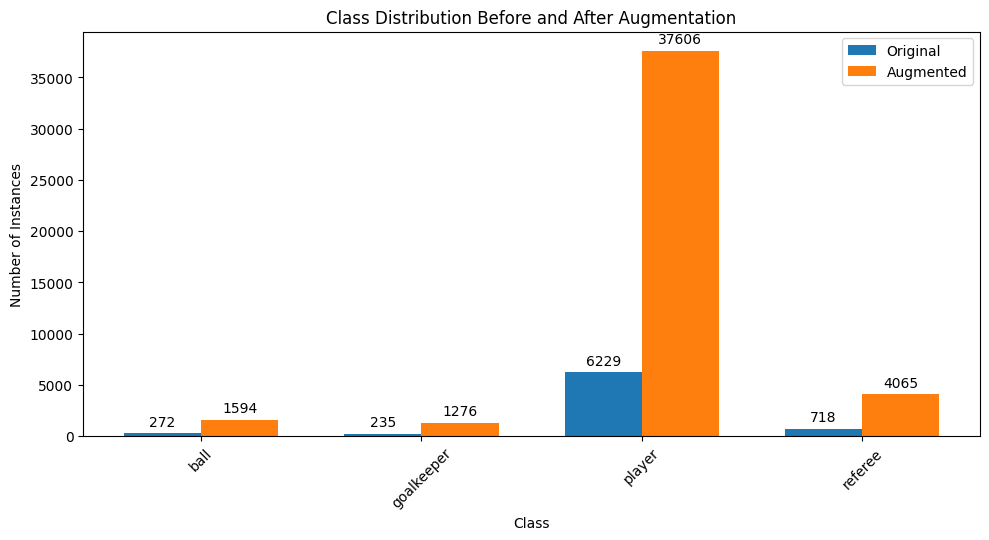

In [21]:
# plot combined class distribution

plot_combined_class_distribution(original_class_counts, augmented_class_counts, class_names, 'Class Distribution Before and After Augmentation')